In [13]:
# | hidden: true
# | echo: false
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# some personal style settings to make the plots look nice
# and save some space in the notebook
plt.style.use("../style.mplstyle")

Now that we've talked about inference in depth, it is time to talk about **prediction**. In this lecture, we will build up to the basics of linear regression, which is a powerful tool for making predictions based on data.

## Predictions from patterns

How do we make predictions? We typically look for patterns in the data and use those patterns to make informed guesses about future outcomes. 

:::{.callout-note title="Why not memorize?"}
Why not just memorize the data? Think about a dataset like this:

| Name | Apples / Day |
|------|--------------|
| Alice | 3 |
| Bob   | 5 |
| Charlie | 2 |

If you were asked to predict how many apples a new person would eat per day, you could memorize the data and say "Alice eats 3 apples, Bob eats 5 apples, Charlie eats 2 apples." You would be 100% correct on this dataset! But what if you were asked to predict how many apples a new person would eat? You would have no idea, because your memorized list only contains the data you have seen already. You have no way to make a prediction about a new person like Dave:
| Name | Apples / Day |
|------|--------------|
| Dave | ? |

So, we need a better strategy!

More broadly, this is called **generalization**: the ability to make predictions about new data based on patterns learned from existing data. 
:::

Consider the following dataset of the heights (in inches) of a sample of adults. The dataset also records the height of their parents, so we'll refer to the adults as "children" and their parents as "parents" in this context. ^[The Galton dataset is is a classic dataset in statistics, named after Sir Francis Galton, who studied the relationship between the heights of parents and their children. The study is the origin of the term "linear regression" and is murkily involved in the eugenics movement of the early 1900s. Data from [here](https://doi.org/10.7910/DVN/T0HSJ1).]

In [14]:
#| code-fold: show
galton = pd.read_csv("../data/galton-stata11.tsv", sep="\t", dtype={"male": bool, "female": bool, "gender": "category", "family": "category"})
galton.head() # first few rows of the dataset

,family,father,mother,gender,height,kids,male,female
0,1,78.5,67.0,M,73.2,4,True,False
1,1,78.5,67.0,F,69.2,4,False,True
2,1,78.5,67.0,F,69.0,4,False,True
3,1,78.5,67.0,F,69.0,4,False,True
4,2,75.5,66.5,M,73.5,4,True,False


Let's say I asked you to predict the height of another child not in the dataset. Assume they're from the same population as the children in the dataset. You have no other information about the child. How would you do it?

The most straightforward thing to do is ask yourself: "What is the typical height of a child in this dataset?" You could then use that typical height as your prediction. This is the simplest kind of pattern recognition: finding the average value in the dataset and using it as a prediction. 

The mean height of children in the Galton dataset is 66.76 inches.


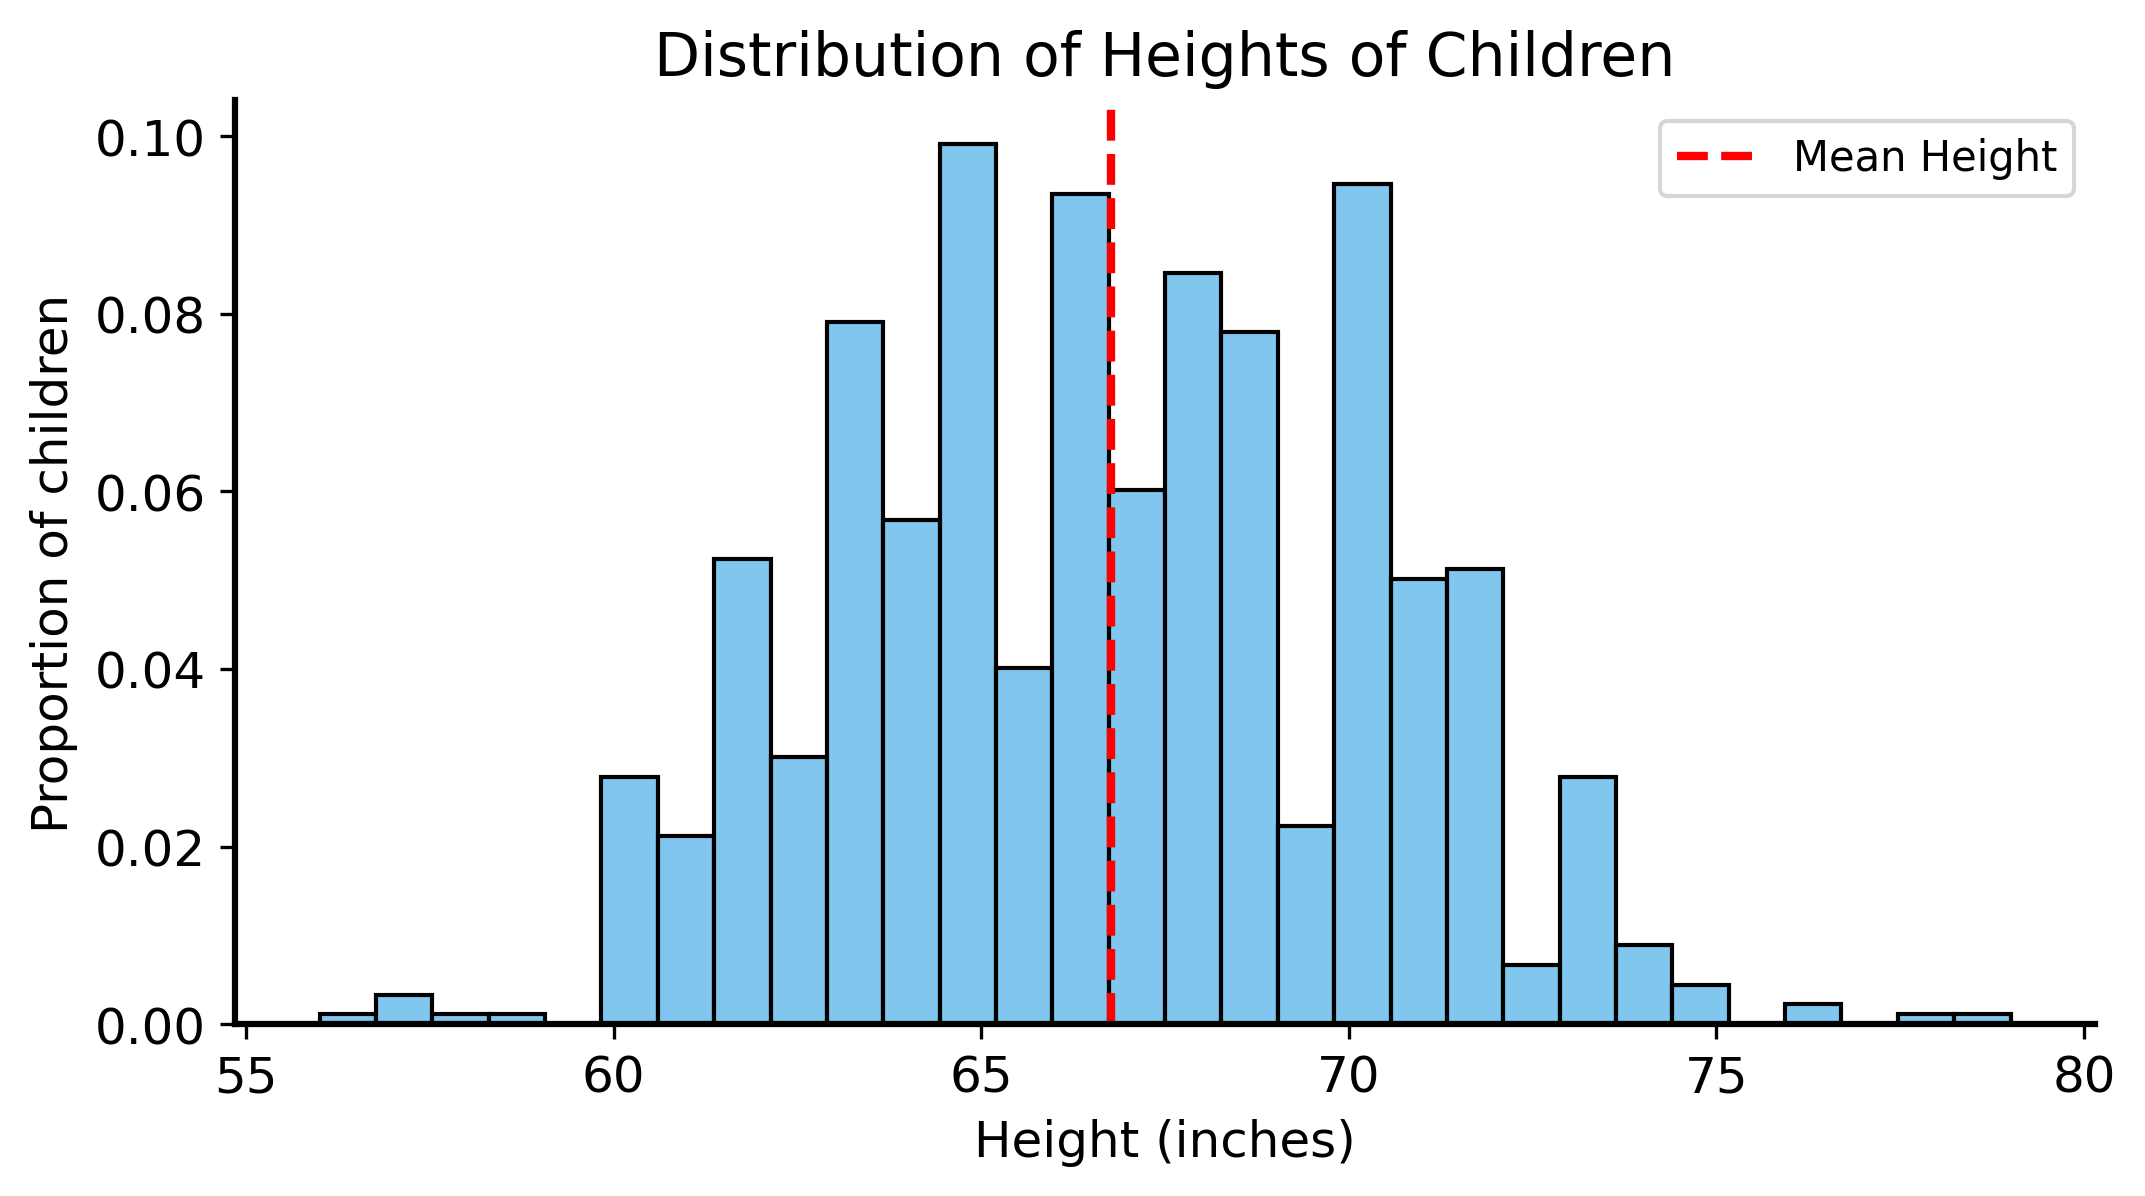

In [15]:
#| code-fold: show

# print the mean height of children in the dataset
mean_height = galton["height"].mean()
print(f"The mean height of children in the Galton dataset is {mean_height:.2f} inches.")

# plot the distribution of heights
plt.figure(figsize=(8, 4))
sns.histplot(galton["height"], stat="proportion", bins=30)
plt.xlabel("Height (inches)")
plt.ylabel("Proportion of children")
plt.title("Distribution of Heights of Children")
plt.axvline(mean_height, color="red", linestyle="--", label="Mean Height")
plt.legend()
plt.show()

This isn't bad as a first guess, and you actually can't do any better than this if you have no other information about the child. 

But what if you had more information? For example, say you had other information about the child (besides their own height), such as their sex (male / female) or the heights of their parents. If you think that these factors might be related to the child's height, they should inform your prediction.

Let's start by just plotting the heights of the children in the dataset against the heights of their parents. This will help us visualize the relationship between the two variables.

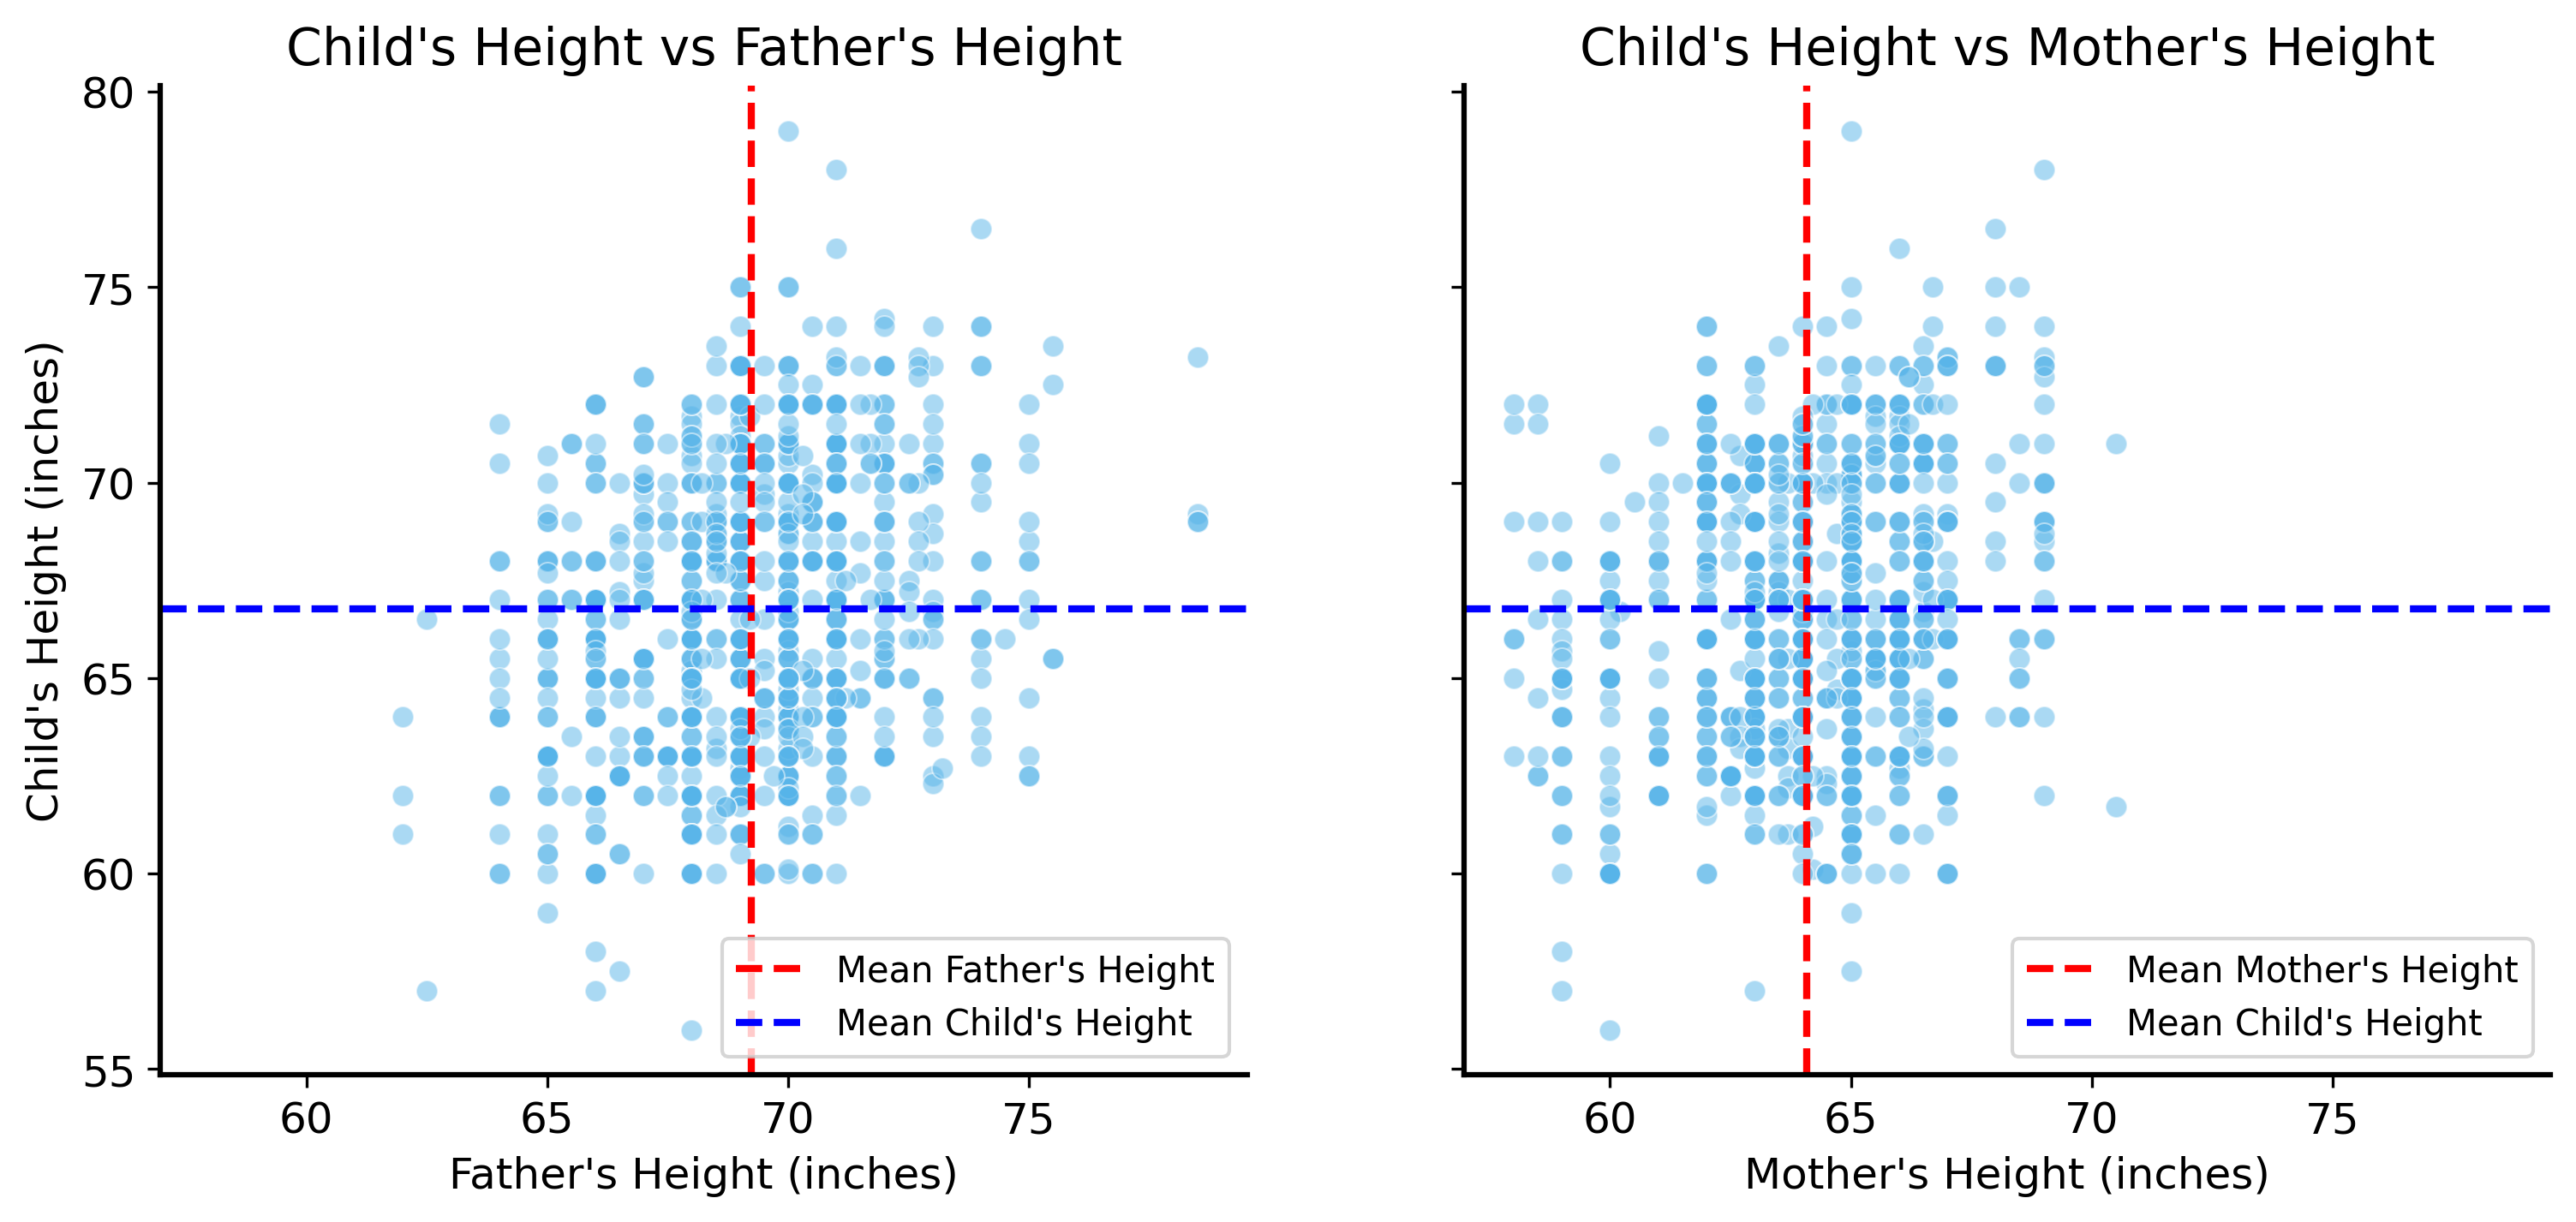

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharey=True, sharex=True)
# plot the heights of children against the heights of their fathers
sns.scatterplot(data=galton, x="father", y="height", ax=ax[0], alpha=0.5)
ax[0].set_xlabel("Father's Height (inches)")
ax[0].set_ylabel("Child's Height (inches)")
ax[0].set_title("Child's Height vs Father's Height")
ax[0].axvline(galton["father"].mean(), color="red", linestyle="--", label="Mean Father's Height")
ax[0].axhline(mean_height, color="blue", linestyle="--", label="Mean Child's Height")
ax[0].legend(loc='lower right')

# plot the heights of children against the heights of their mothers
sns.scatterplot(data=galton, x="mother", y="height", ax=ax[1], alpha=0.5)
ax[1].set_xlabel("Mother's Height (inches)")
ax[1].set_ylabel("Child's Height (inches)")
ax[1].set_title("Child's Height vs Mother's Height")
ax[1].axvline(galton["mother"].mean(), color="red", linestyle="--", label="Mean Mother's Height")
ax[1].axhline(mean_height, color="blue", linestyle="--", label="Mean Child's Height")
ax[1].legend(loc='lower right')

Notice how the naive prediction we made earlier (the average height of the children), shown as a blue dashed line, totally ignores the heights of the parents. It's constant across the entire plot, and does not capture any of the variation in the data.

You may, based on your own experience and understanding of the world, expect that children with taller parents tend to be taller themselves. It sure looks that way in the plot above -- the taller children tend to have taller parents, and the shorter children tend to have shorter parents. It's not always the case, by any means, but it seems to be a general trend.

But **how much** taller? We want to quantify this relationship, so that we can get a formula for predicting a child's height based on their parents' heights. Mathematically, we want to define a function $f$ that takes the heights of the parents as input and returns the predicted height of the child as output. 

#### Preparing the data

Dealing with two separate parents is cumbersome. Can we combine the heights of the parents into a single number that represents "the height of the parents"? One way to do this is to take the average of the two heights. 

This is problematic at the moment. Based on the plot it seems that the father's height has a different relationship with the child's height than the mother's height does. The trends are similar, but the plots have different shapes. This is probably because men and women tend to have different average heights (as you can see in the plot above). Also because men are taller on average, they contribute more to the average height of the parents than women do.

There is a useful trick we can use to simplify this. We can put the heights of men and women in the dataset on the same scale by **standardizing** them. 

$$
\begin{align*}
\text{standardized female height} = \frac{\text{height} - \text{average of female heights}}{\text{standard deviation of female heights}} \\
\text{standardized male height} = \frac{\text{height} - \text{average of male heights}}{\text{standard deviation of male heights}} \\
\end{align*}
$$

This procedure transforms all of the heights into a common scale, where the average is zero and the standard deviation is one. This process is called **standardization** or **z-scoring**. 

Let's do this and plot the standardized heights of the parents against the heights of the children.

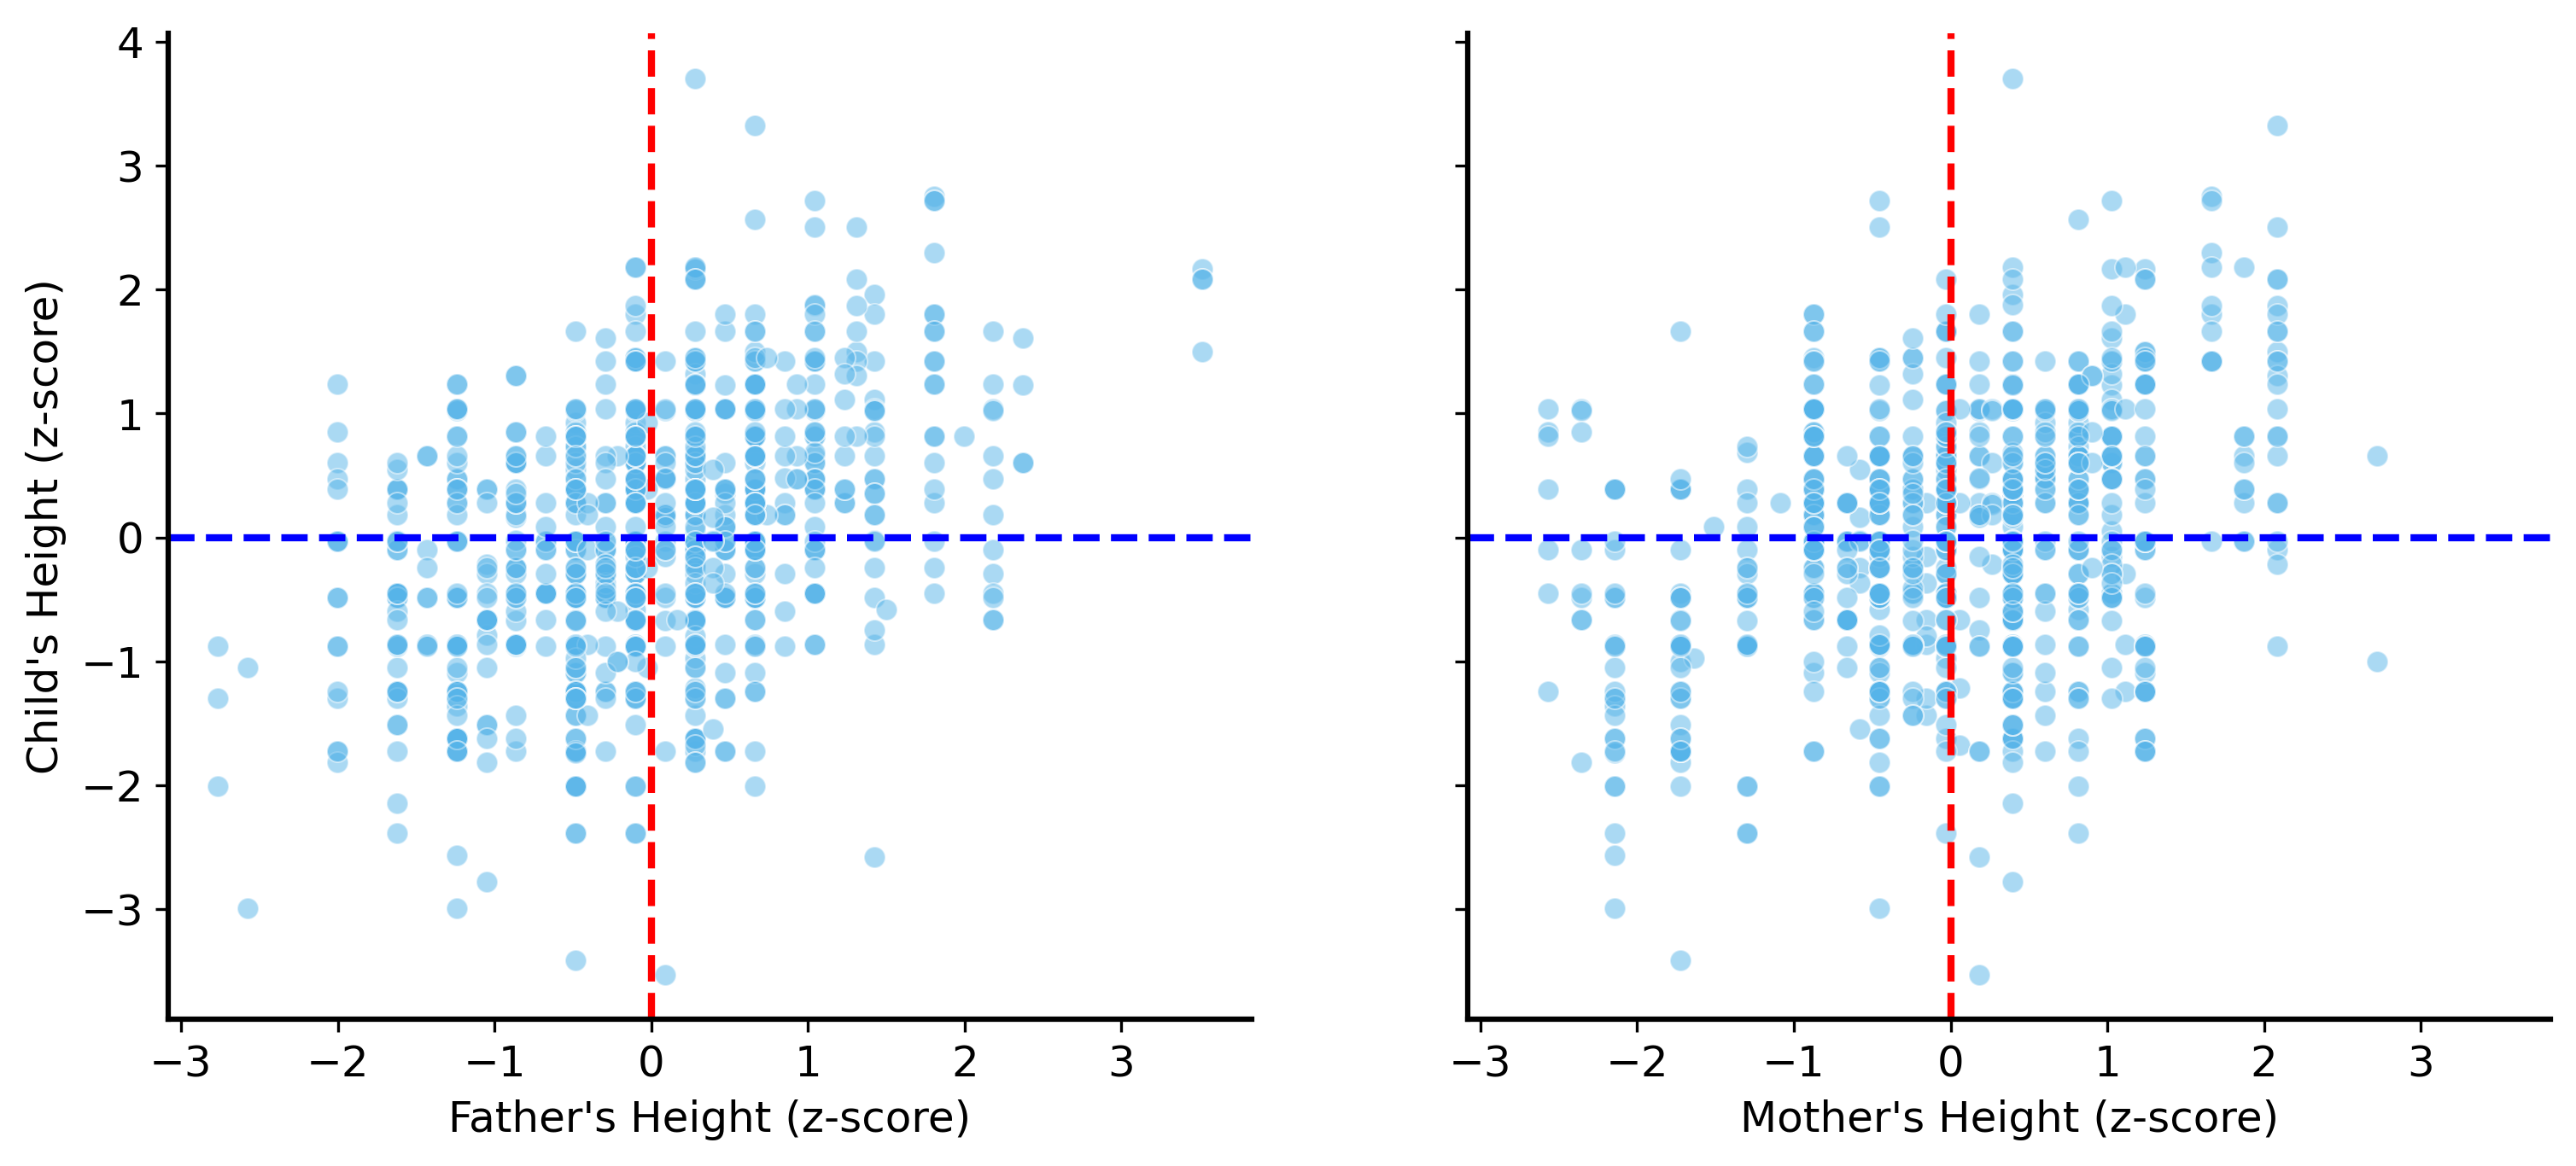

In [17]:
# include all female and male heights (parents and children)
mother_heights = galton[["mother", "family"]].drop_duplicates()["mother"].values
female_child_heights = galton[galton["gender"] == "F"]["height"].values
female_heights = np.concatenate([mother_heights, female_child_heights])

father_heights = galton[["father", "family"]].drop_duplicates()["father"].values
male_child_heights = galton[galton["gender"] == "M"]["height"].values
male_heights = np.concatenate([father_heights, male_child_heights])

# calculate the mean and standard deviation of the heights of mothers and fathers
female_mean = female_heights.mean()
female_std = female_heights.std(ddof=1)
male_mean = male_heights.mean()
male_std = male_heights.std(ddof=1)

# transform the heights to z-scores
galton["mother_z"] = (galton["mother"] - female_mean) / female_std
galton["father_z"] = (galton["father"] - male_mean) / male_std
galton.loc[galton["gender"] == "F", "height_z"] = (galton.loc[galton["gender"] == "F", "height"] - female_mean) / female_std
galton.loc[galton["gender"] == "M", "height_z"] = (galton.loc[galton["gender"] == "M", "height"] - male_mean) / male_std

# plot the z-scores of the heights of children against the z-scores of their fathers
fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharey=True, sharex=True)
sns.scatterplot(data=galton, x="father_z", y="height_z", ax=ax[0], alpha=0.5)
ax[0].set_xlabel("Father's Height (z-score)")
ax[0].set_ylabel("Child's Height (z-score)")
ax[0].axvline(0, color="red", linestyle="--")
ax[0].axhline(0, color="blue", linestyle="--")

# plot the z-scores of the heights of children against the z-scores of their mothers
sns.scatterplot(data=galton, x="mother_z", y="height_z", ax=ax[1], alpha=0.5)
ax[1].set_xlabel("Mother's Height (z-score)")
ax[1].set_ylabel("Child's Height (z-score)")
ax[1].axvline(0, color="red", linestyle="--")
ax[1].axhline(0, color="blue", linestyle="--")  

Now we have put the heights of the parents on the same scale, so we can combine them into a single number that represents "the height of the parents". We can do this by taking the average of the standardized heights of the parents.

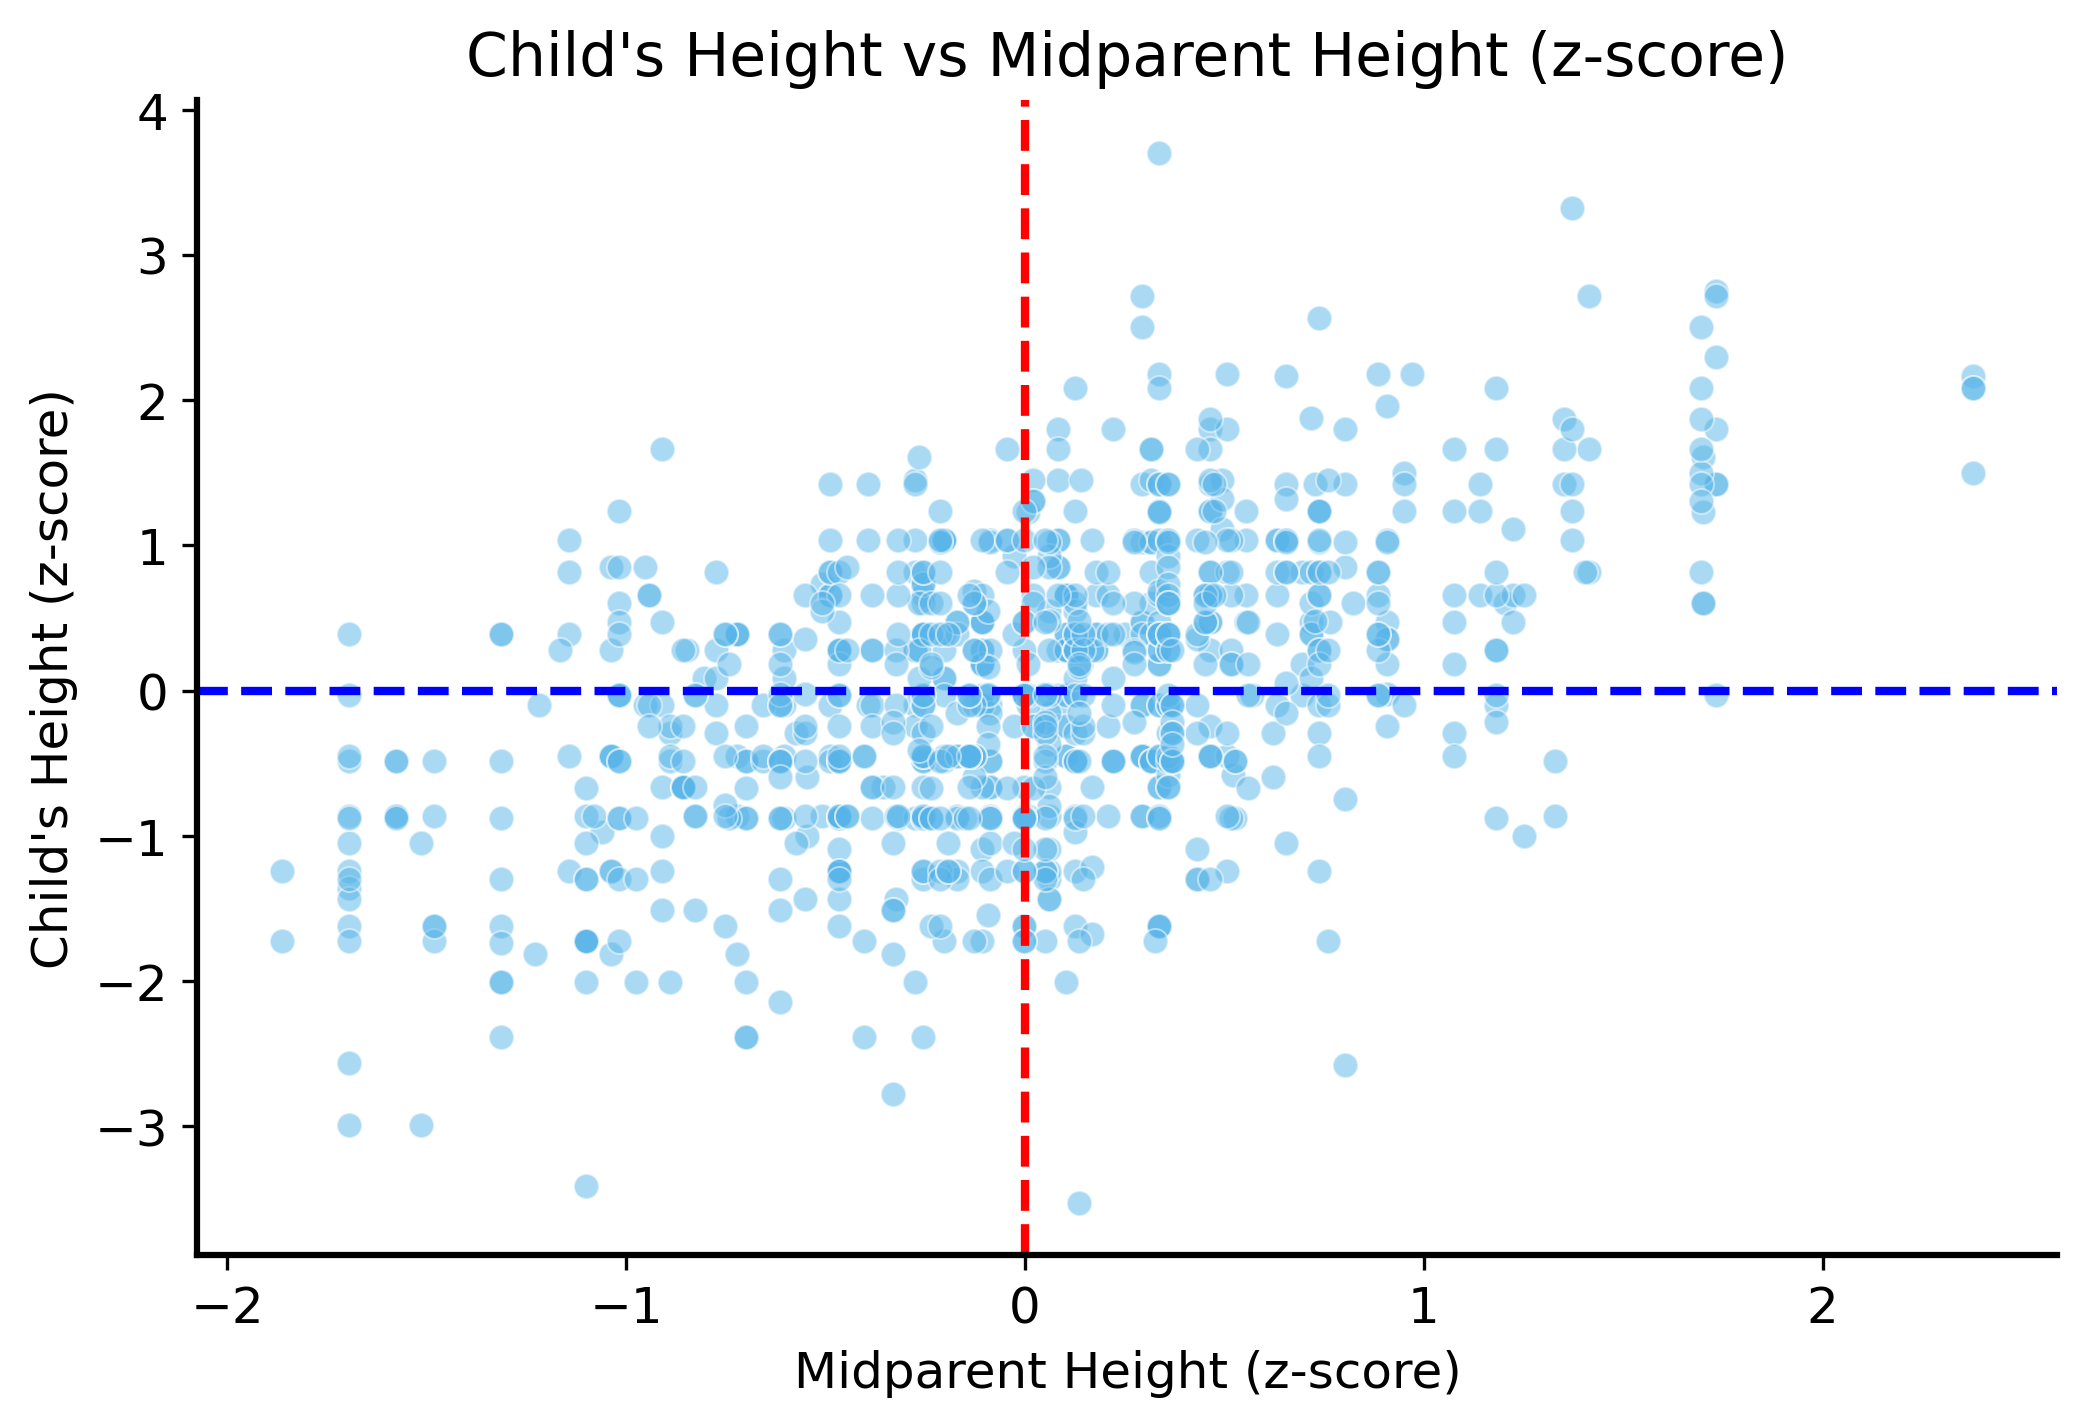

In [18]:
galton["midparent"] = (galton["mother_z"] + galton["father_z"]) / 2

# plot the z-scores of the heights of children against the midparent z-scores
plt.figure(figsize=(8, 5))
sns.scatterplot(data=galton, x="midparent", y="height_z", alpha=0.5)
plt.xlabel("Midparent Height (z-score)")
plt.ylabel("Child's Height (z-score)")
plt.axvline(0, color="red", linestyle="--")
plt.axhline(0, color="blue", linestyle="--")
plt.title("Child's Height vs Midparent Height (z-score)")
plt.show()

Nice! It seems like this retains the relationship between the heights of the parents and the heights of the children, but now we have a single number that represents the height of the parents.

Let's go back to the units we care about predicting, though. It's ok to use standardized heights for the parents, but we want to predict the height of the child in inches.

Text(0.5, 1.0, "Child's Height vs Midparent Height (Z-score)")

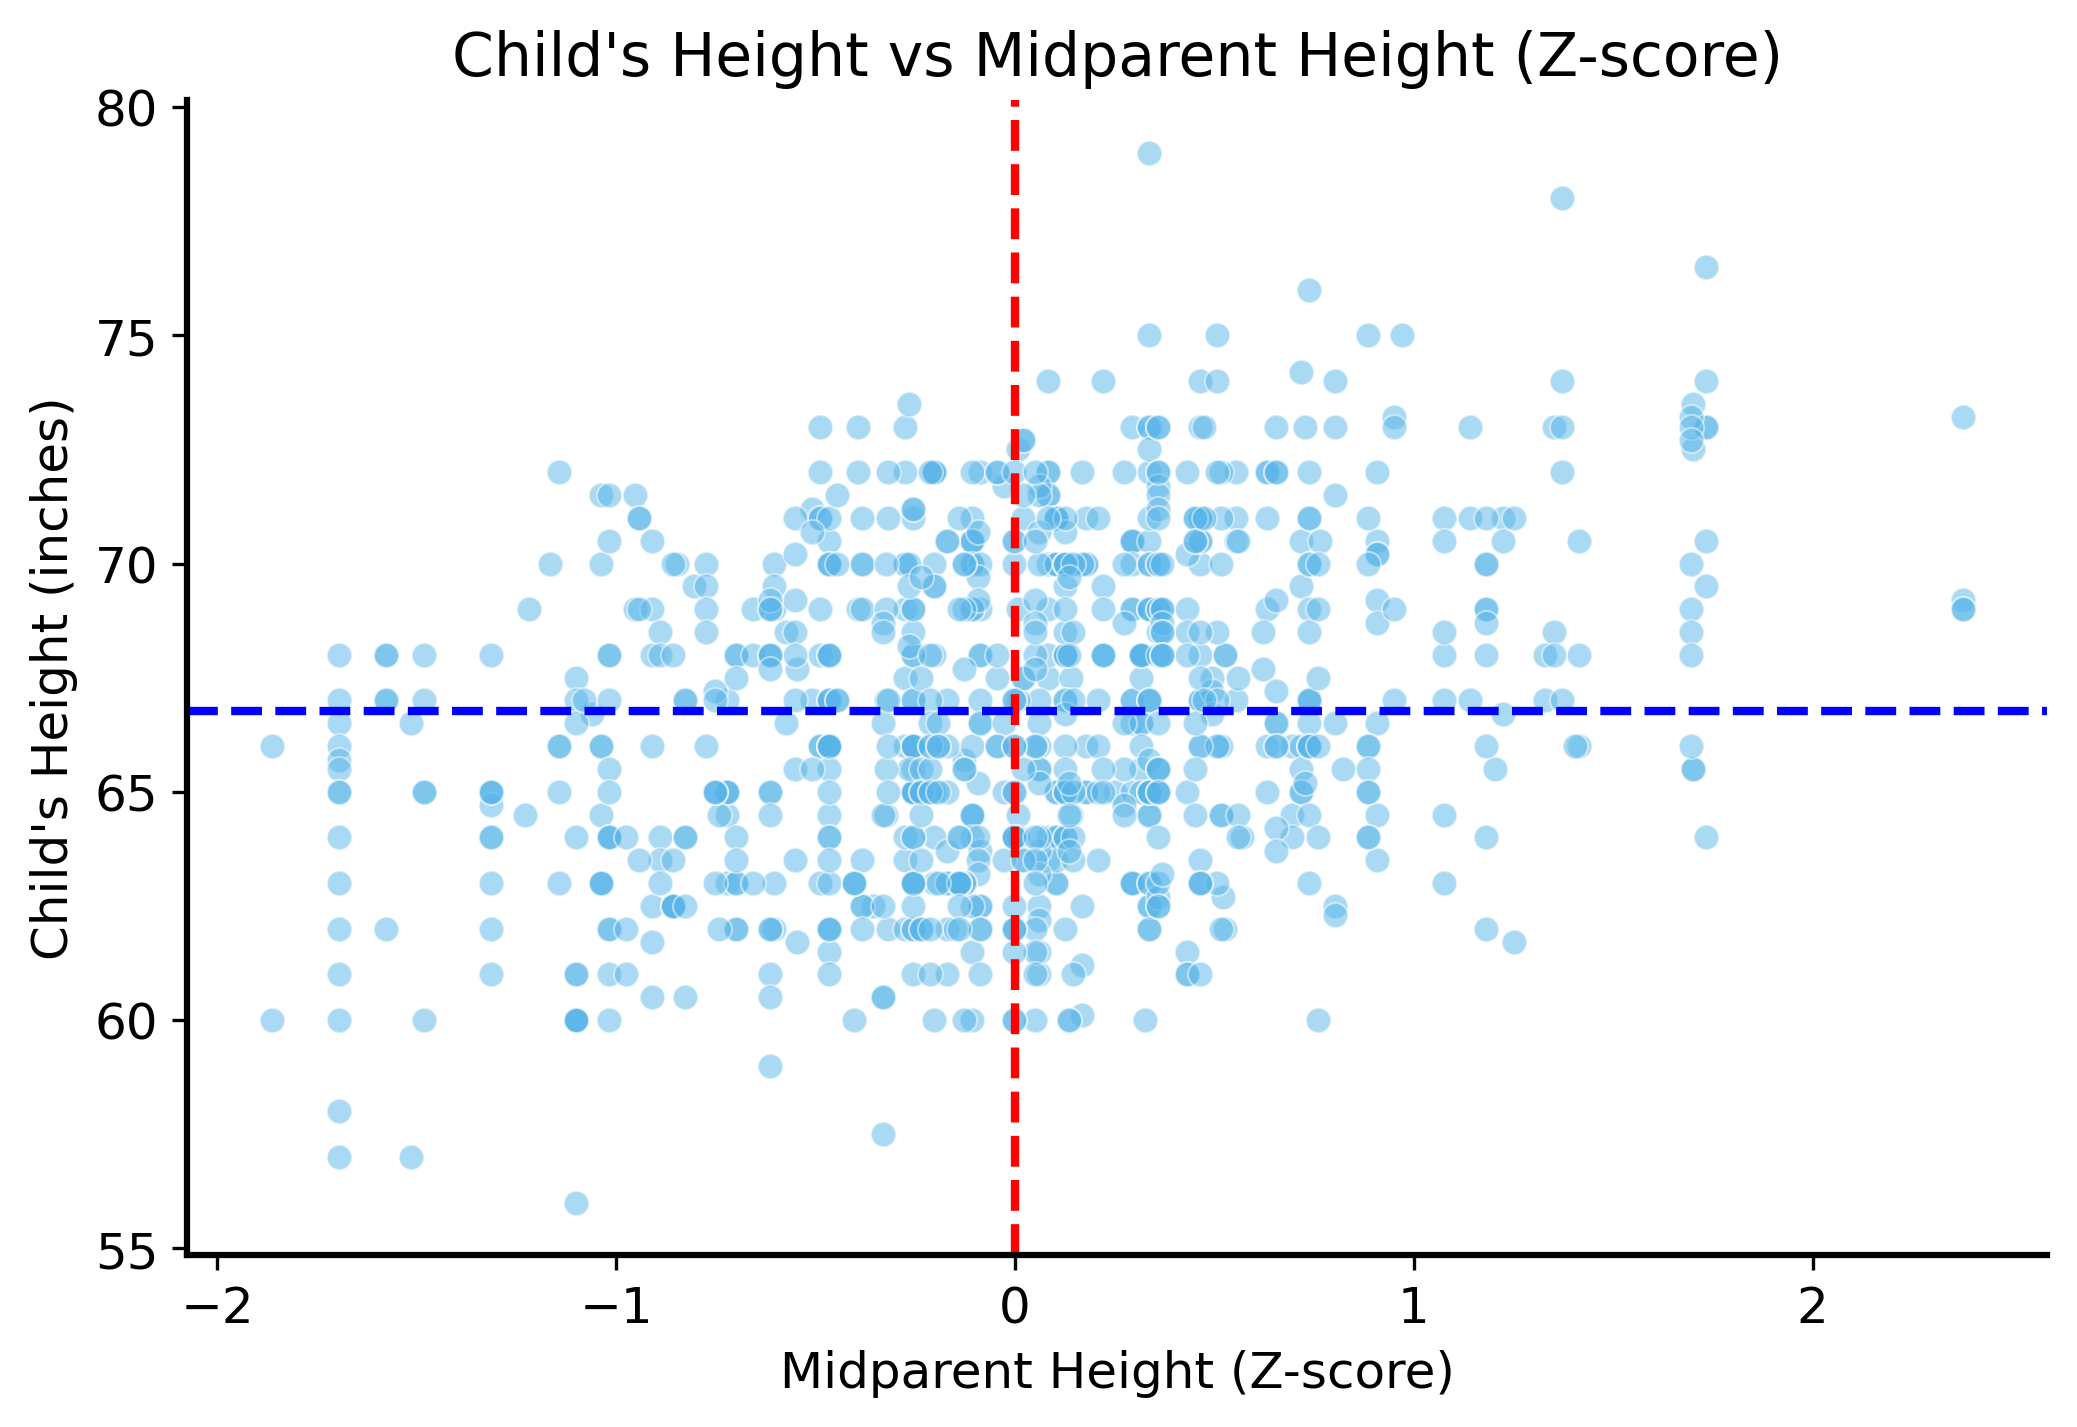

In [19]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.scatterplot(data=galton, x="midparent", y="height", alpha=0.5)
plt.xlabel("Midparent Height (Z-score)")
plt.ylabel("Child's Height (inches)")
plt.axvline(0, color="red", linestyle="--")
plt.axhline(mean_height, color="blue", linestyle="--", label="Mean Child's Height")
plt.title("Child's Height vs Midparent Height (Z-score)")

### Quantifying relationships
Back to our question: **how much** taller are the children of tall parents? 

The simplest way to quantify this relationship is to use a linear function, which is a function of the form $f(x) = mx + b$, where $m$ is the slope of the line and $b$ is the y-intercept. A linear function has a constant rate of change, which means that for every unit increase in the input, the output increases by a fixed amount. Fitting a linear function to data is called **linear regression**.

In our case, we choose to *model* the relationship between the heights of the parents and the heights of the children as a linear function. 

$$\text{predicted height of child} = \text{slope} \times \text{midparent height} + \text{intercept}$$

Note that our first model, the average height of the children, is a special case of this linear function where the slope is zero and the intercept is the average height of the children.

What *should* the slope be? Basically, we want it to be whatever value makes the predicted heights of the children as close to the actual heights of the children as possible.

We can use a statistical technique called **ordinary least squares** (OLS) to find the best-fitting line for our data. OLS minimizes the (squared) distance between the predicted heights of the children and the actual heights of the children.

::: {.callout-note title="Why squared?" collapse=true}
OLS minimizes $(\text{predicted height} - \text{actual height})^2$. Why squared? There are two main reasons:
1. Squaring the differences ensures that we don't have negative values canceling out positive values
2. When you square a number, it becomes larger as the number gets larger. This means that larger errors are penalized more heavily than smaller errors. So you'd rather be off by 1 inch 10 times (squared error of 10) than be off by 10 inches once (squared error of 100). This helps us find a line that is close to all of the points and avoids being too far off on any one point.

*Advanced note:* If you like calculus, the other benefit of squared errors is that they are differentiable (think about a parabola $y = x^2$ - the slope is always changing, but it never has a sharp corner). This is a big difference compared to absolute errors, which have a sharp corner at zero (the slope of $|x|$ is not defined at zero, where it changes from -1 to 1).
:::

Let's fit a linear regression model to the data and see what the best-fitting line looks like.

::: {.callout-note title="Specifying regression models" collapse=true}
Statistical software packages have built-in functions for fitting many common models to data. There are a variety of packages that do pretty much the same thing, and they all have their own syntax for specifying the model you want to fit.



Some packages accept a formula as input, which specifies the relationship between the variables. The "formula" is a string that describes the model you want to fit, and has its own syntax. In this case, we want to predict the height of the child based on the midparent height, so we use the formula `height ~ midparent`. The `~` symbol separates the outcome variable (the variable we want to predict) from the input variable (the variable we are using to make the prediction). The `+` symbol can be used to add more input variables to the model, but in this case we only have one input variable. The intercept is included by default, so we don't need to specify it explicitly.
:::

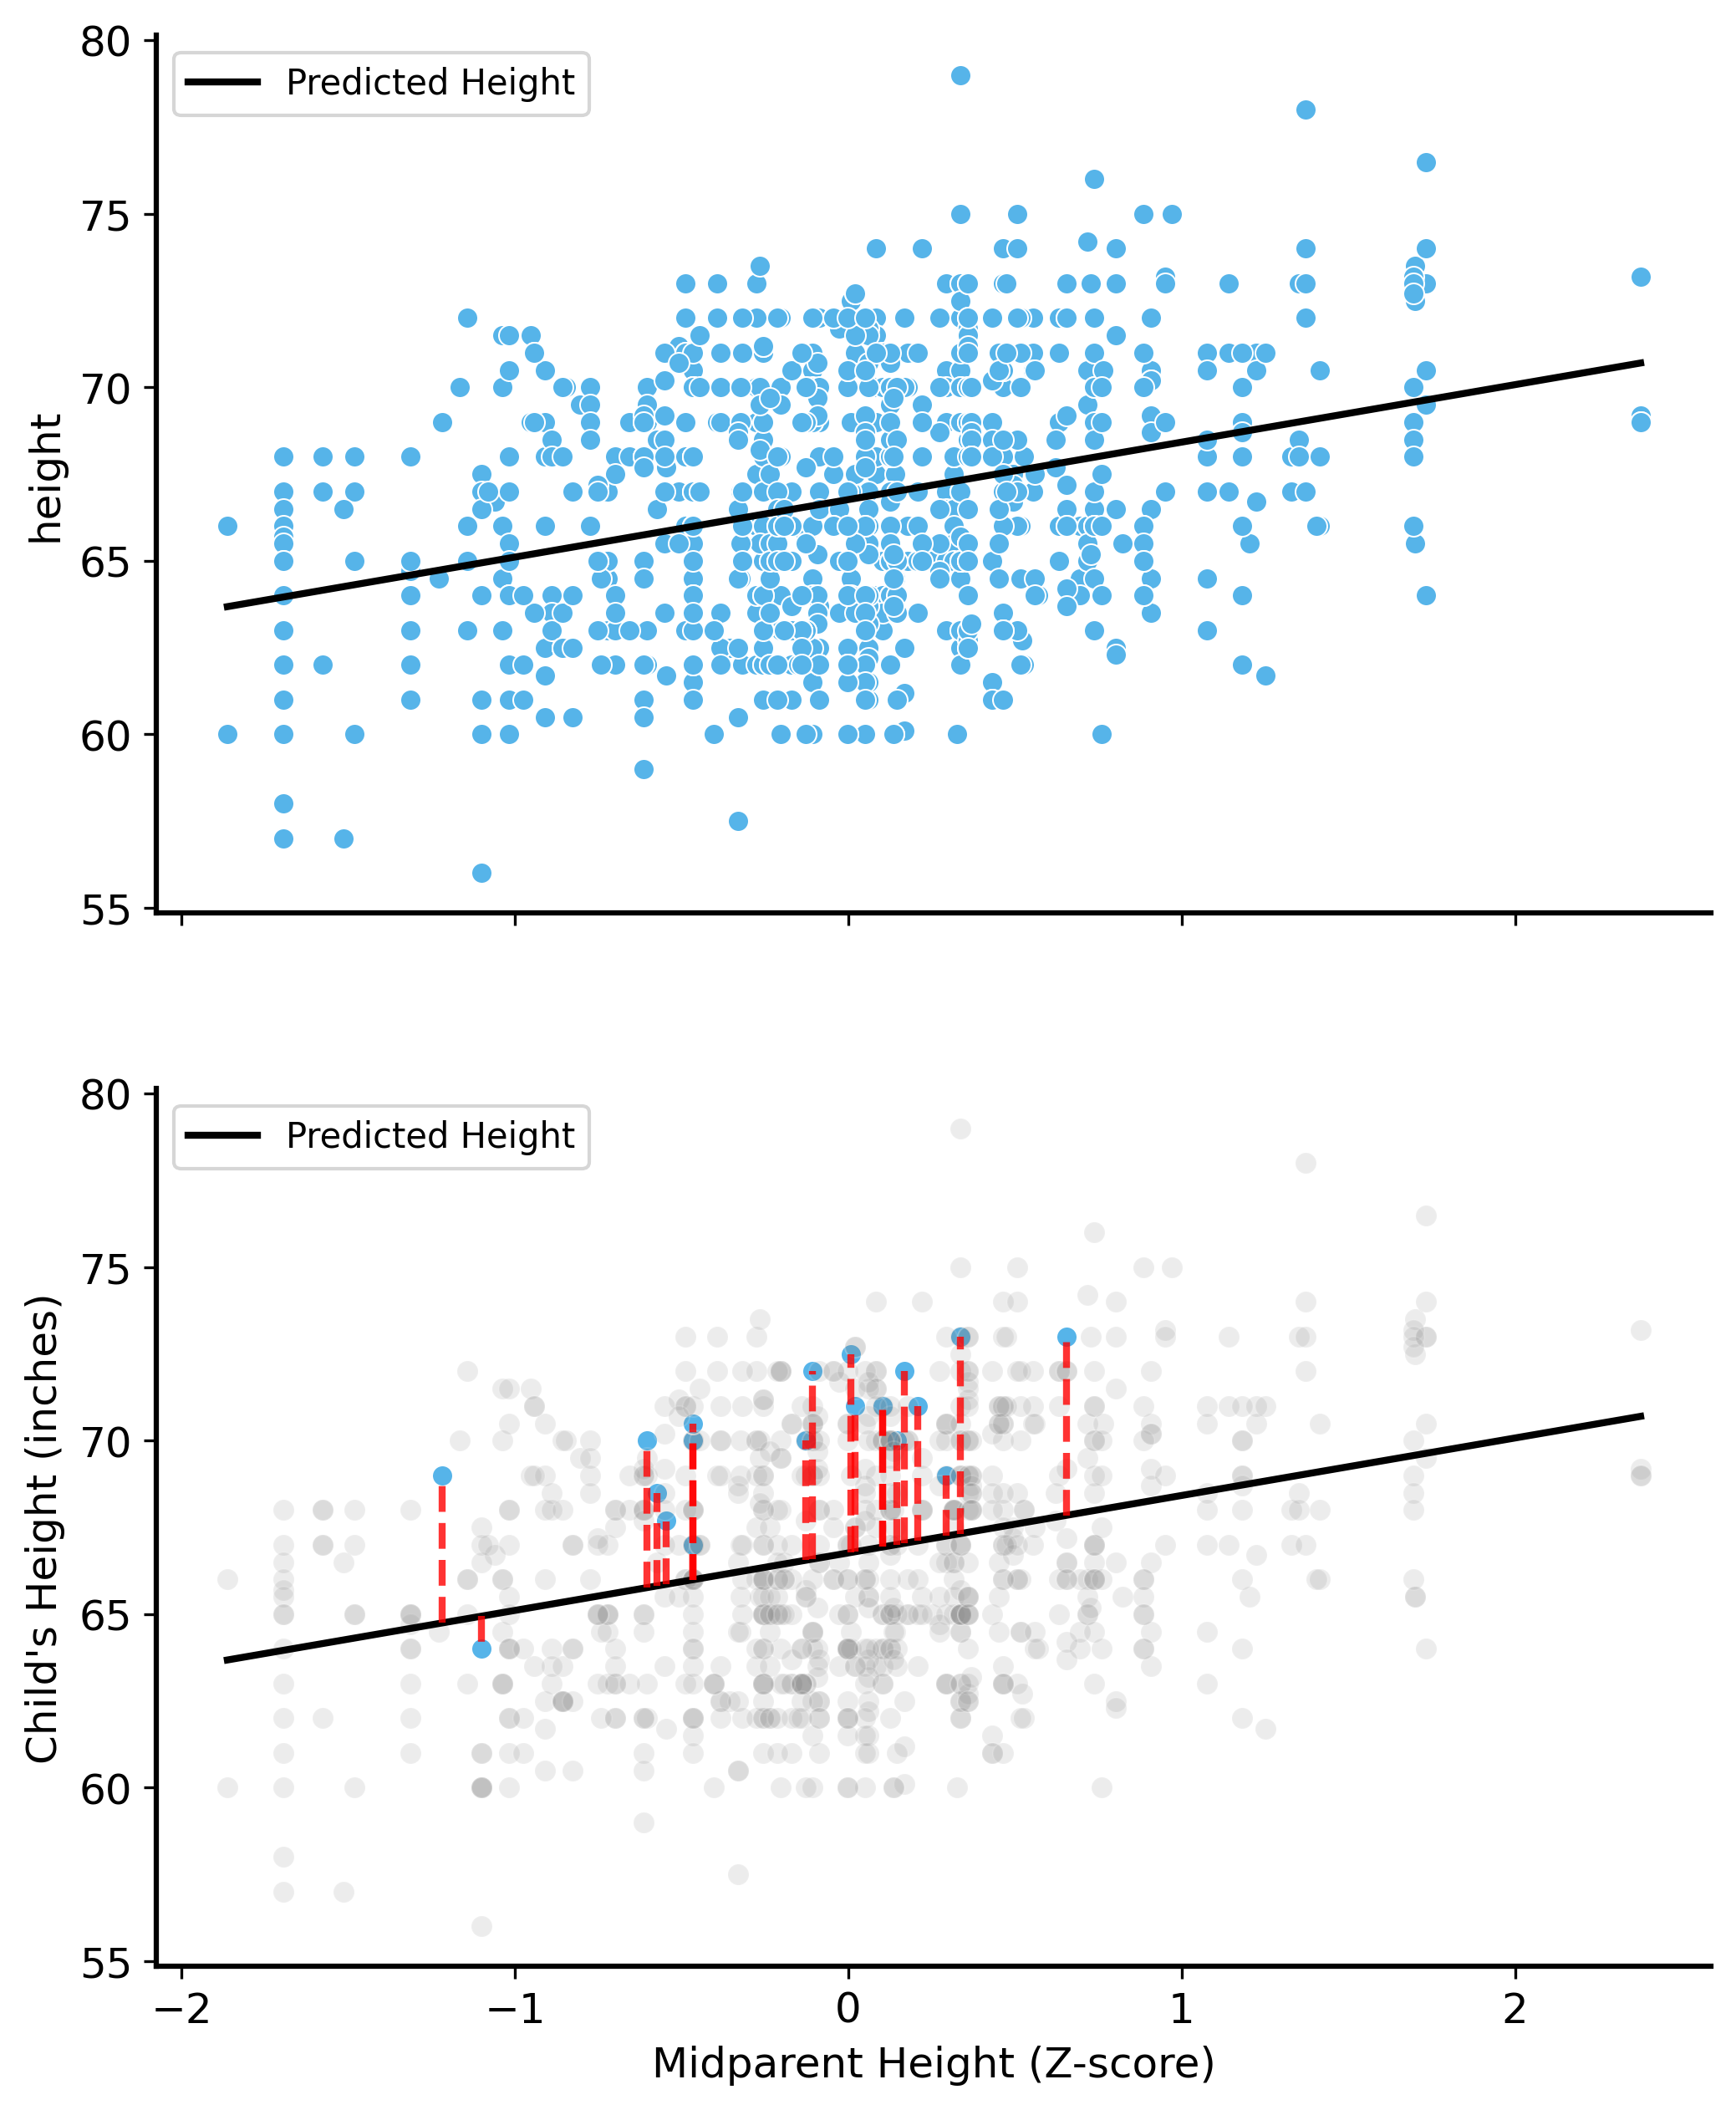

In [20]:
#| code-fold: show
# fit OLS and draw the prediction errors
from statsmodels.formula.api import ols
# fit a linear regression model to the data
model = ols("height ~ midparent", data=galton).fit()
# print the summary of the model
predicted_heights = model.predict(galton["midparent"]).values
errors = galton["height"] - predicted_heights

select_idx = galton["family"].drop_duplicates().sample(20).index.values # avoid overplotting a few non-overlapping families
remaining_idx = galton.index.difference(select_idx).values

fig, ax = plt.subplots(2, 1, figsize=(8, 10), sharex=True)

sns.scatterplot(data=galton, x="midparent", y="height", ax=ax[0])
sns.lineplot(x=galton["midparent"], y=predicted_heights, color="k", label="Predicted Height", ax=ax[0])

sns.scatterplot(data=galton.iloc[select_idx], x="midparent", y="height", alpha=1., ax=ax[1])
sns.scatterplot(data=galton.iloc[remaining_idx], x="midparent", y="height", alpha=0.15, color="gray", ax=ax[1])
plt.xlabel("Midparent Height (Z-score)")
plt.ylabel("Child's Height (inches)")
sns.lineplot(x=galton["midparent"], y=predicted_heights, color="k", label="Predicted Height", ax=ax[1])
for i in select_idx:
    # draw a line from the predicted height to the actual height
    ax[1].plot([galton["midparent"].iloc[i], galton["midparent"].iloc[i]], [predicted_heights[i], galton["height"].iloc[i]], color="red", linestyle="--", alpha=.8)

In the second plot, we show the prediction errors for a few datapoints. The red lines show the difference between the predicted height of the child and the actual height of the child. OLS finds the best fit that minimizes the sum of the squared lengths of these red lines.

So what's the slope that answers our question? We can extract the parameters of the model to find out. The slope is the parameter associated with the midparent height variable.

In [21]:
#| code-fold: show
model.params

Intercept    66.765946
midparent     1.656486
dtype: float64

So what exactly can we say? 

The slope of a line $y = mx + b$ is the change in $y$ for a one-unit increase in $x$. So, in our case, the slope is the change in the predicted height of the child for a one-unit increase in the midparent height.

So, for every one unit increase in the midparent height, the predicted height of the child increases by about 1.7 inches. 

This probably seems confusing because the midparent heights are standardized and averaged. It means that if the parents' heights are on average one standard deviation above the mean height, the predicted height of the child is 1.7 inches taller than the average height of the children in the dataset.

So how did we do in terms of prediction? 

Let's take a look at the distribution of the errors. 

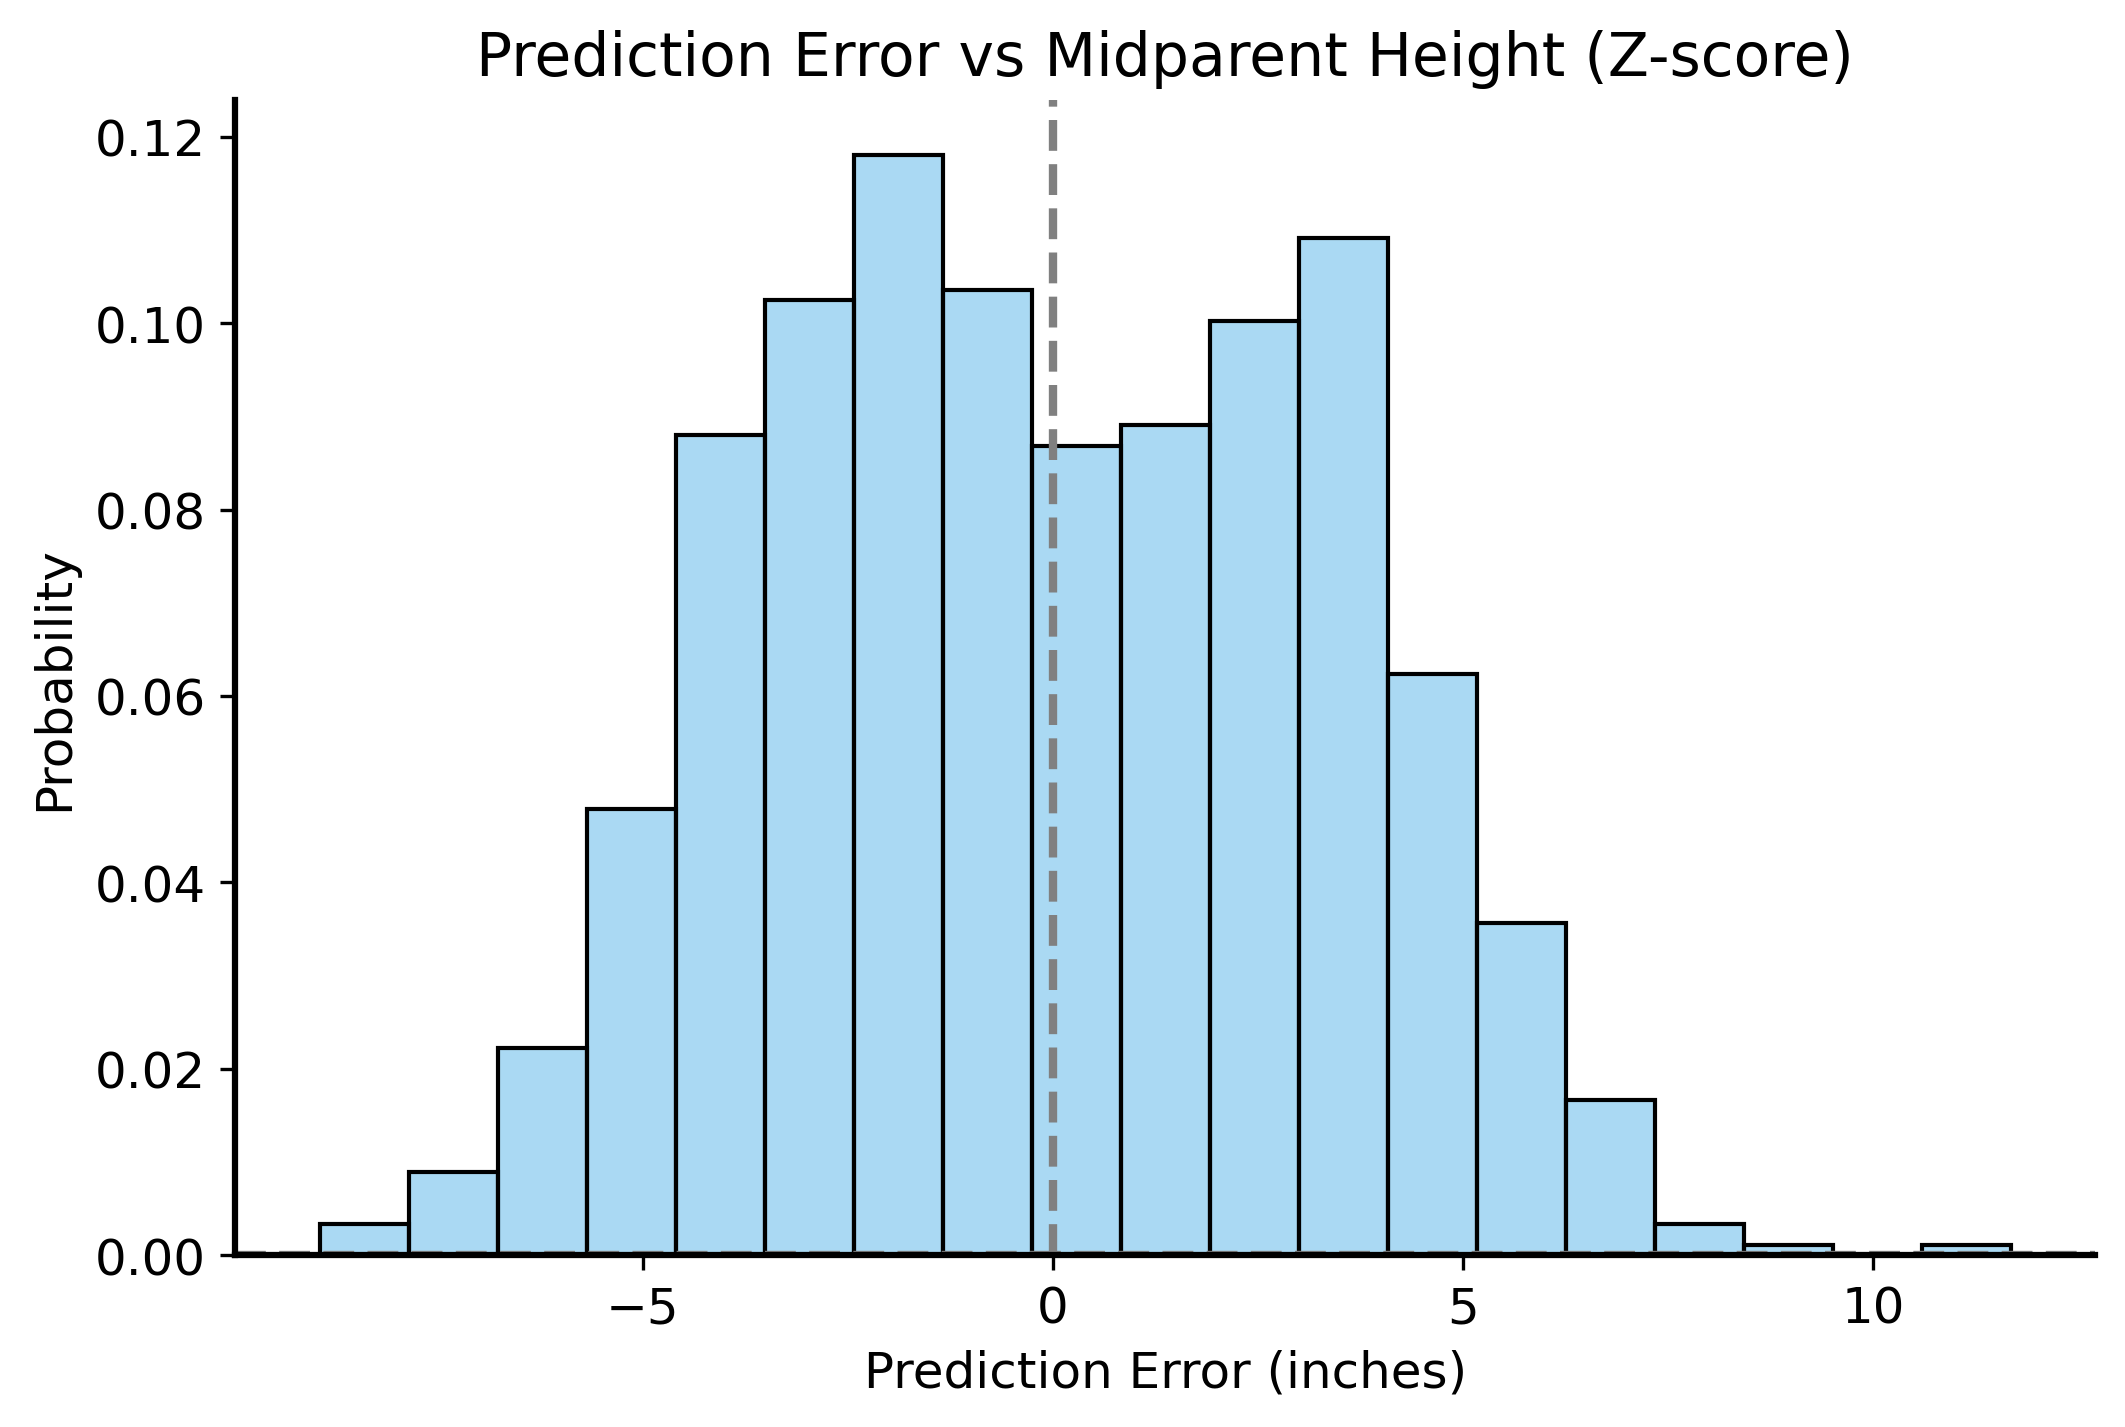

In [22]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.histplot(x=errors, alpha=0.5, stat="probability", ax=ax)
ax.set_xlabel("Prediction Error (inches)")
ax.axhline(0, color="gray", linestyle="--")
ax.axvline(0, color="gray", linestyle="--")
ax.set_title("Prediction Error vs Midparent Height (Z-score)")
plt.show()

We often evaluate our predictions by studying the mean and standard deviation of the prediction errors. 
We want the mean to be close to zero, which means that our predictions are on average correct. You don't want to be consistently over- or under-predicting. The standard deviation tells us how much the prediction errors vary.

In [23]:
#| code-fold: show
print(f"Mean prediction error: {np.mean(errors):.2e} \nStandard deviation of prediction error: {np.std(errors):.2f}")

Mean prediction error: -2.43e-14 
Standard deviation of prediction error: 3.39


Specifically, the standard deviation is called the "Root Mean Squared Error" (RMSE), and it tells us how far off our predictions are from the actual values on average:
$$\text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (\text{predicted height}_i - \text{actual height}_i)^2}$$
So, in our case the RMSE is about 3.4. This means that on average, our predictions are off by about 3.4 inches. 

Let's compare this to the RMSE of the naive prediction we made earlier (the average height of the children). 

In [24]:
#| code-fold: show
naive_rmse = np.sqrt(np.mean((galton["height"] - mean_height) ** 2))
print(f"Naive RMSE: {naive_rmse:.2f} inches")

Naive RMSE: 3.58 inches


Notice anything else interesting about the residual distribution? It's centered around zero, and most of the residuals close to that mean -- it's approximately normal!

We skipped over this important detail before, but that's actually a key assumption of the linear regression model. The residuals (or you can think of them as "noise" -- variation in the data that we can't explain with our model) should be normally distributed. 

This highlights the connection between linear regression and the kind of probabilistic statistical models we have been discussing in this course all along. The regression model treats the variable we are predicting (the height of the child) as a random variable itself. It has an expected value that depends in a linear way on the input variable, but it also has some inherent variability.

So the linear regression model predictions can be written as:
$$y \sim \mathcal{N}(\beta_0 + \beta_1 x, \sigma^2)$$

where $\beta_0$ is the intercept, $\beta_1$ is the slope, and $\sigma^2$ is the variance of the residuals.

The consequence of this variability is that, just like our previous models, our data-driven conclusions are subject to uncertainty from sampling. We might just **happen** to get a sample where the children of tall parents are shorter than average, and get a slope that is negative. 

This is why we need to be careful about interpreting the results of our regression model. We'll return to the hypothesis testing framework in the next lecture, and show how it can be applied to regression models.